# U-Net BUSI Segmentation — Project Summary Notebook

"""
This notebook summarizes the full segmentation project on the BUSI dataset.
It includes:
- Dataset overview
- Model architecture summary
- Training results (loss, accuracy, Dice)
- Visual predictions from the test set
"""

# Dataset Overview

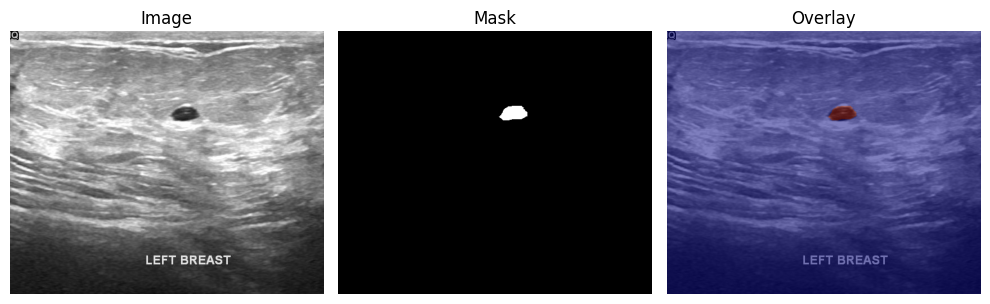

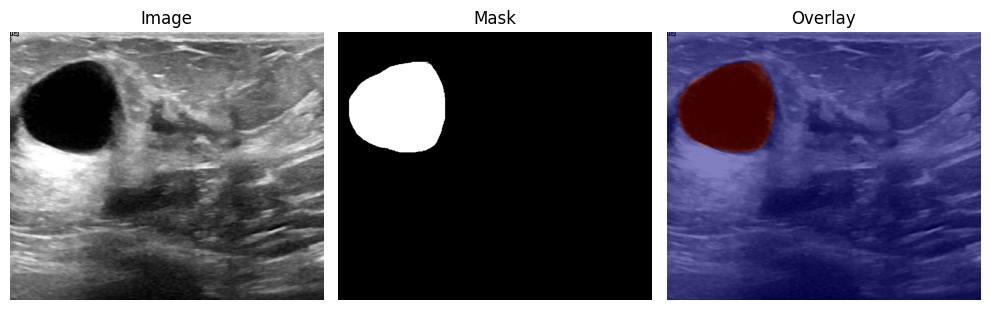

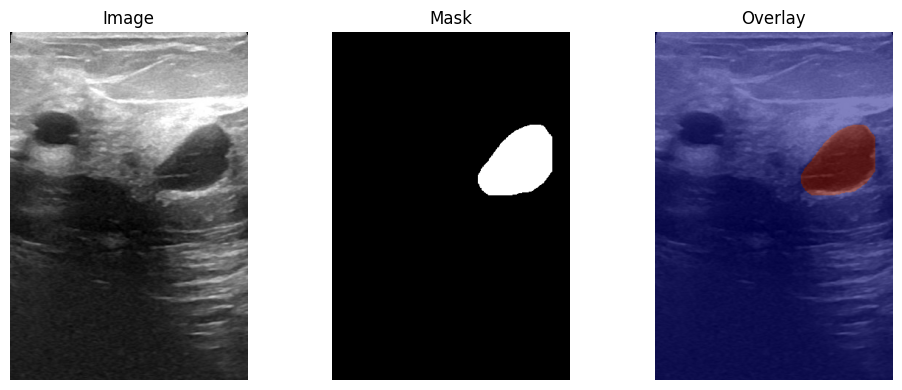

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

project_root = Path().resolve().parent  
image_dir = project_root / "data" / "images"
mask_dir = project_root / "data" / "masks"

image_files = sorted(image_dir.glob("*.png"))[:3]

for img_path in image_files:
    filename = img_path.name
    mask_path = mask_dir / filename

    image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Mask")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(image, cmap="gray")
    plt.imshow(mask, cmap="jet", alpha=0.5)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# Model Architecture Summary

In [8]:
import os
import torch
from torchvision.utils import make_grid
from PIL import Image
import sys
import os
sys.path.append(os.path.abspath(".."))


from src.unet import BetterUNet
from src.dataset import BUSIDataset

# 📁 Define paths
IMAGE_SIZE = (256, 256)
MODEL_PATH = "/Users/clarachoukroun/unet-busi-project/results/unet_final.pt"
DATA_PATH = "/Users/clarachoukroun/unet-busi-project/data"
TEST_PRED_PATH = "/Users/clarachoukroun/unet-busi-project/results/test_preds"

# 📦 Load model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = BetterUNet(init_features=32).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# 🔍 Summary
from torchsummary import summary
summary(model, input_size=(1, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
        DoubleConv-7         [-1, 32, 256, 256]               0
         MaxPool2d-8         [-1, 32, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]          18,496
      BatchNorm2d-10         [-1, 64, 128, 128]             128
             ReLU-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,928
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

# Training Results

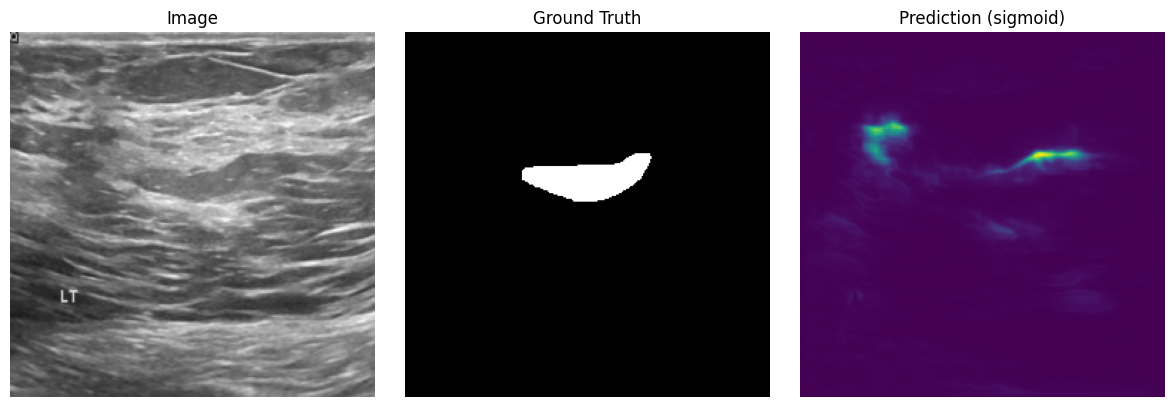

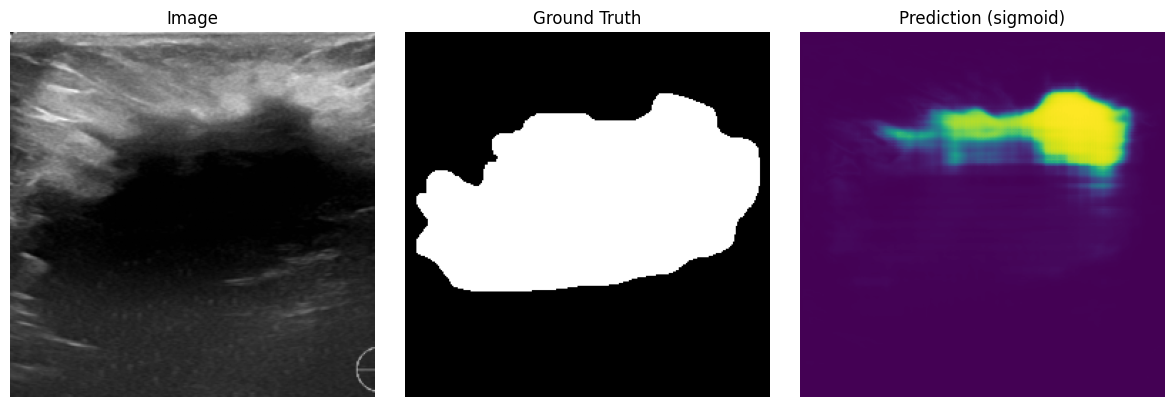

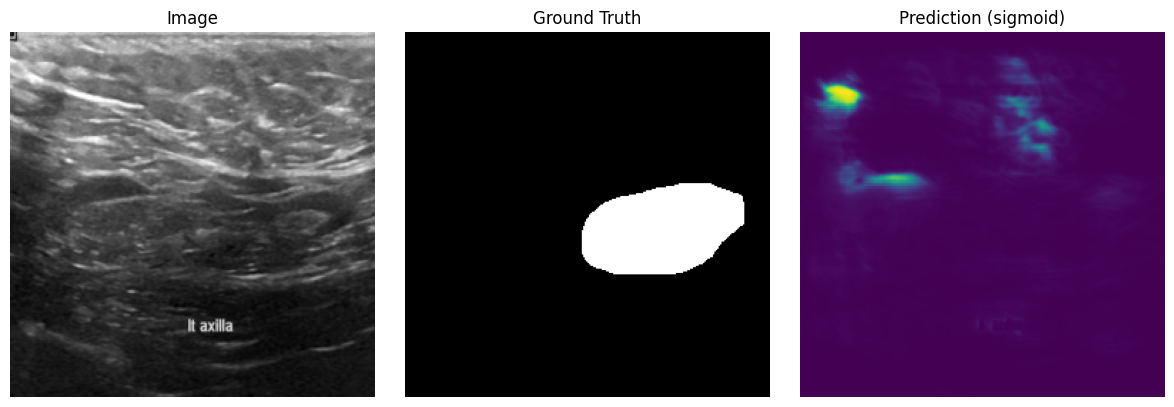

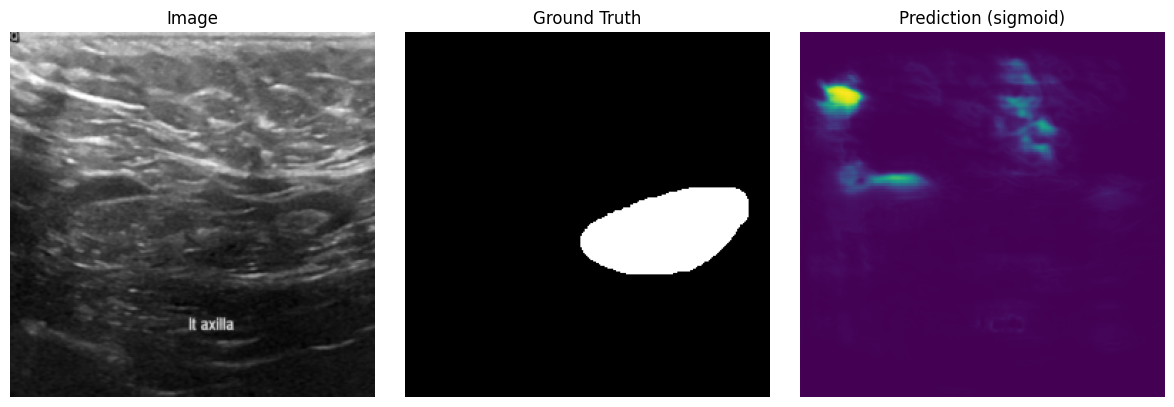

📈 Mean Dice score on test set: 0.4963
📊 Mean Accuracy on test set: 0.9111


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# ✅ Fonctions utiles
def compute_dice(pred, target, eps=1e-8):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection + eps) / (pred.sum() + target.sum() + eps)

def compute_accuracy(pred, target):
    pred = (pred > 0.5).float()
    return (pred == target).float().mean()

# 📦 Dataloaders
from torch.utils.data import DataLoader, random_split
from src.dataset import BUSIDataset

dataset = BUSIDataset("/Users/clarachoukroun/unet-busi-project/data/images", "/Users/clarachoukroun/unet-busi-project/data/masks", size=(256, 256))
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
_, _, test_set = random_split(dataset, [train_size, val_size, test_size])
test_loader = DataLoader(test_set, batch_size=1)

model.eval()
dice_scores = []
acc_scores = []

n_visuals = 4
shown = 0

with torch.no_grad():
    for i, (img, mask) in enumerate(test_loader):
        img, mask = img.to(DEVICE), mask.to(DEVICE)
        pred = torch.sigmoid(model(img))

        # ⬇️ Scores
        dice = compute_dice(pred, mask)
        acc = compute_accuracy(pred, mask)
        dice_scores.append(dice.item())
        acc_scores.append(acc.item())

        # ⬇️ Visualisation
        if shown < n_visuals:
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(img[0].cpu().squeeze(), cmap="gray")
            axs[0].set_title("Image")
            axs[1].imshow(mask[0].cpu().squeeze(), cmap="gray")
            axs[1].set_title("Ground Truth")
            axs[2].imshow(pred[0].cpu().squeeze(), cmap="viridis")
            axs[2].set_title("Prediction (sigmoid)")
            for ax in axs:
                ax.axis("off")
            plt.tight_layout()
            plt.show()
            shown += 1

print(f" Mean Dice score on test set: {np.mean(dice_scores):.4f}")
print(f" Mean Accuracy on test set: {np.mean(acc_scores):.4f}")
